# SciPy based transforms

In the last notebook `getting_started_with_robot_ik.ipynb` we have familiarized ourselves with the concept of Forward and Inverse Kinematics (IK) and implemented a simple IK solver for a 3DOF leg using trigonometry. In this notebook we will use SciPy to implement a more advanced IK solver.

SciPy, a Python library built upon NumPy, provides a wide array of mathematical algorithms and functions that are valuable for robotics, including linear algebra, which is of interest here.

The first step is to convert our forward kinematics code from custom Points and hand crafted function to use matrix transforms for rotation and translation.

Alongside the conversion, we are going to bring all the algorithms to work in full 3D space, not just 2D projections.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from point import Point, Line
from scipy.spatial.transform import Rotation as R


def forward_kinematics(
    coxa_length, femur_length, tibia_length, alpha, beta, gamma, start_height=2, body_length=5
):
    # Convert angles to radians for scipy
    alpha_rad = np.radians(alpha)
    beta_rad = np.radians(beta)
    gamma_rad = np.radians(gamma)

    # Define initial points in local coordinates
    start = np.array([0, start_height, 0])
    body_local = np.array([body_length, 0, 0])
    coxa_local = np.array([coxa_length, 0, 0])
    femur_local = np.array([femur_length, 0, 0])
    tibia_local = np.array([tibia_length, 0, 0])

    # Create rotation matrices
    r_alpha = R.from_rotvec(np.array([0, 0, 1]) * alpha_rad)
    r_beta = R.from_rotvec(np.array([0, 0, 1]) * beta_rad)
    r_gamma = R.from_rotvec(np.array([0, 0, 1]) * gamma_rad)

    # Calculate global positions using transformations
    body_pos = start + body_local

    # Apply alpha rotation to coxa
    coxa_rotated = r_alpha.apply(coxa_local)
    coxa_pos = body_pos + coxa_rotated

    # Apply alpha+beta rotation to femur
    r_alpha_beta = r_alpha * r_beta
    femur_rotated = r_alpha_beta.apply(femur_local)
    femur_pos = coxa_pos + femur_rotated

    # Apply alpha+beta+gamma rotation to tibia
    r_alpha_beta_gamma = r_alpha_beta * r_gamma
    tibia_rotated = r_alpha_beta_gamma.apply(tibia_local)
    tibia_pos = femur_pos + tibia_rotated

    # Create Point objects for visualization
    start_point = Point(start[0], start[1], 'Start')
    body_point = Point(body_pos[0], body_pos[1], rf'$\alpha$={alpha}°')
    coxa_point = Point(coxa_pos[0], coxa_pos[1], rf'$\beta$={beta}°')
    femur_point = Point(femur_pos[0], femur_pos[1], rf'$\gamma$={gamma}°')
    tibia_point = Point(tibia_pos[0], tibia_pos[1], 'Foot')

    # Return lines connecting the points
    return (
        Line(start_point, body_point, 'Body'),
        Line(body_point, coxa_point, 'Coxa'),
        Line(coxa_point, femur_point, 'Femur'),
        Line(femur_point, tibia_point, 'Tibia'),
    )


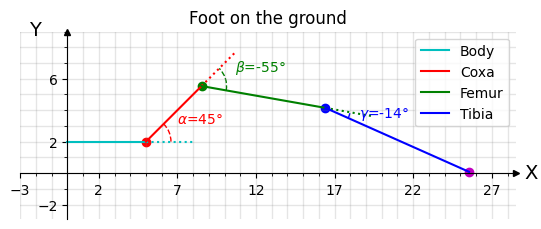

In [6]:
%matplotlib inline

from plotting import plot_leg_with_points

coxa_length = 5
femur_length = 8
tibia_length = 10


model = forward_kinematics(coxa_length, femur_length, tibia_length, 45, -55, -14)

_ = plot_leg_with_points(model, 'Foot on the ground', link_labels='legend')